In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/raw/creditcard.csv')

### All Transformation

In [3]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    QuantileTransformer
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA


default_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

Time_rbf_transformer = FunctionTransformer(
    rbf_kernel,
    feature_names_out='one-to-one',
    kw_args={
        'Y':[[79000]],
        'gamma':1e-8
    }
)

q_heavy_tail_pipeline = make_pipeline(
    QuantileTransformer(output_distribution='normal'),
    StandardScaler()
)

# V2, V5, V7 with Amount
V2_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V5_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V7_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)


all_transformation = ColumnTransformer(
    transformers=[
        ('Time_rbf', Time_rbf_transformer, ['Time']),
        ('heavy_tail', q_heavy_tail_pipeline, ['V1', 'V2', 'V3', 'V4', 'V5',
                                               'V6','V7', 'V8', 'V9', 'V10',
                                               'V11', 'V12', 'V14', 'V15',
                                               'V16', 'V17', 'V18', 'V19', 'V20',
                                               'V21', 'V22', 'V23', 'V24', 'V25',
                                               'V27', 'V28', 'Amount']),
        ('V2_amount', V2_amount_pipeline, ['V2', 'Amount']),
        ('V5_amount', V5_amount_pipeline, ['V5', 'Amount']),
        ('V7_amount', V7_amount_pipeline, ['V7', 'Amount'])
        
    ],
    remainder=default_pipeline,
    force_int_remainder_cols=False
)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(df,
                               test_size=0.2,
                               stratify=df['Class'],
                               random_state=10
                               )

In [6]:
X_train, X_test = train.drop('Class', axis=1), test.drop('Class', axis=1)
y_train, y_test = train['Class'], test['Class']

## LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [9]:
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}], # this gamma is optimized
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['l1', 'l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['sag'],
        'logistic_r__penalty': ['l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],  
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['elasticnet'],
        'logistic_r__l1_ratio': [0.3, 0.5, 0.8]
    }
]

In [11]:
lr_gs = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

In [12]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0x000001C4F0DB7560>,
                                                                                             k...
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__penalty': ['l2'],
                          'logistic_r__solver': ['sag'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__l1_ratio': [0.3, 0.5, 0.8],
                          'logistic_r__penalty': ['elasticnet'],
                          'logistic_r__solver': ['saga'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]}],
             scoring='neg_mean_absolute_error')

In [13]:
lr_gs.best_params_

{'logistic_r__l1_ratio': 0.8,
 'logistic_r__penalty': 'elasticnet',
 'logistic_r__solver': 'saga',
 'transformation__Time_rbf__kw_args': {'Y': [[79000]], 'gamma': 1e-08}}

In [167]:
MME_lr = -lr_gs.best_score_
MME_lr

0.030507581908753755

In [15]:
lr_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x000001C4F0DB7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('logistic_r',
                 LogisticRegression(l1_ratio=0.8, max_iter=1000, n_jobs=-1,
                                    penalty='elasticnet', random_state=10,
                                    solver='saga'))])

In [16]:
pd.DataFrame(lr_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_r__penalty,param_logistic_r__solver,param_transformation__Time_rbf__kw_args,param_logistic_r__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,143.949663,31.622523,0.349466,0.074146,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.8,"{'logistic_r__l1_ratio': 0.8, 'logistic_r__pen...",-0.030920,-0.027124,-0.032807,-0.031271,-0.030415,-0.030508,0.001871,1
3,182.434379,49.687464,0.437066,0.052040,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.3,"{'logistic_r__l1_ratio': 0.3, 'logistic_r__pen...",-0.030876,-0.027036,-0.032807,-0.031118,-0.030745,-0.030516,0.001892,2
0,193.701258,46.416276,0.490511,0.045065,l1,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l1', 'logistic_r__sol...",-0.030569,-0.027058,-0.032961,-0.031118,-0.030898,-0.030521,0.001921,3
2,93.550227,26.864132,0.518797,0.068199,l2,sag,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.030986,-0.027321,-0.032873,-0.030986,-0.030569,-0.030547,0.001800,4
1,182.732543,45.239216,0.609301,0.095460,l2,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.030832,-0.027102,-0.032764,-0.031469,-0.030701,-0.030573,0.001883,5
4,172.457455,30.694910,0.419376,0.112755,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.5,"{'logistic_r__l1_ratio': 0.5, 'logistic_r__pen...",-0.030613,-0.027519,-0.032785,-0.031337,-0.030701,-0.030591,0.001722,6


In [18]:
# fitting params into model
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            penalty='elasticnet', # elasticnet showed better performance in terms of runtime
            l1_ratio=0.8,
            solver='saga',
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

## Evaluation for LogisticRegression

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [20]:
y_scores_lr = cross_val_predict(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1
)

In [174]:
y_scores_lr.shape

(227845,)

In [242]:
# y_scores_fraud_lr = y_scores_lr[:, 1]  # probability of being a fraud

# if probability is over 0.5 return 1, else return 0
y_pred_lr = (y_scores_lr > 0.5).astype(int)

In [243]:
precision_score(y_train, y_pred_lr)

0.07292093404342483

In [244]:
recall_score(y_train, y_pred_lr)

0.9035532994923858

In [245]:
f1_score(y_train, y_pred_lr)

0.13495072024260804

In [246]:
from sklearn.metrics import precision_recall_curve

In [247]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train, y_score=y_scores_lr)

In [248]:
thresholds.shape

(227147,)

In [249]:
recall.shape

(227148,)

In [250]:
precision.shape

(227148,)

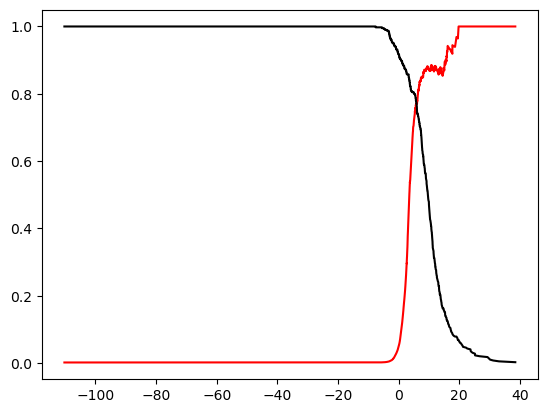

In [251]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.show()

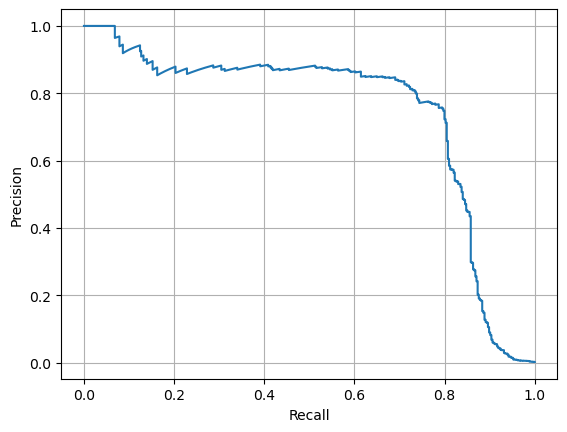

In [252]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

In [253]:
# set threshold based on recall and precision

In [254]:
threshold_75_precision = thresholds[(precision >= 0.75).argmax()]

In [255]:
threshold_75_precision

5.426243905529008

In [256]:
y_pred_75_precision = (y_scores_lr >= threshold_75_precision)

In [257]:
y_pred_75_precision

array([False, False, False, ..., False, False, False])

In [258]:
precision_score(y_train, y_pred_75_precision)

0.7511961722488039

In [259]:
recall_score(y_train, y_pred_75_precision)

0.7969543147208121

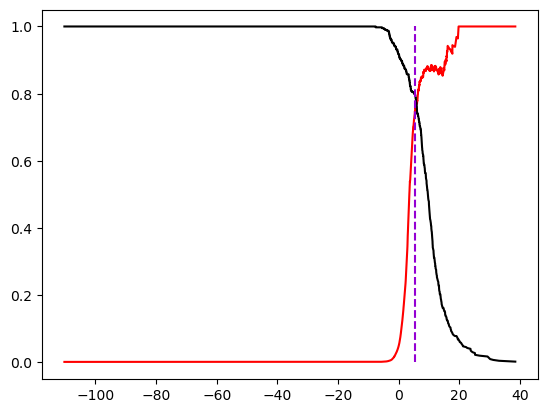

In [260]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')

ax.plot([threshold_75_precision, threshold_75_precision], [0,1], color='darkviolet', ls='--')
plt.show()

In [261]:
from sklearn.metrics import roc_curve

In [262]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_lr)

Text(0, 0.5, 'TP Ratio')

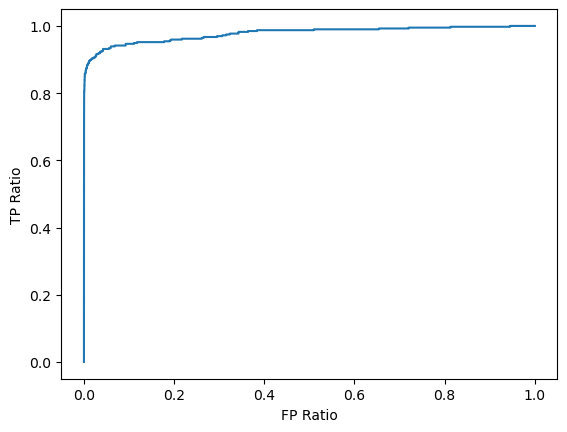

In [263]:
plt.plot(fpr, tpr)
plt.xlabel("FP Ratio")
plt.ylabel("TP Ratio")

In [264]:
# roc_auc_score lr

In [265]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores_lr)

0.9775357093144867

## LGBMClassifier

In [129]:
# !pip install lightgbm

In [130]:
import lightgbm
lightgbm.__version__

'4.6.0'

SMOTE

In [131]:
# !pip install imbalanced-learn

In [132]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# smote = SMOTE(random_state=10)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [133]:
from lightgbm import LGBMClassifier

In [156]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        random_state=10,
        n_jobs=-1,
        # verbose=-1,
    ))
])


In [160]:
lgbm_param_grid = [
    {
        'lgbm__boosting_type':['gbdt'],
        'lgbm__learning_rate':[0.05, 0.1, 0.2],
        'lgbm__num_leaves': [60, 70, 75],
        'lgbm__subsample':[0.5, 0.7, 1],   # subsample should be <= 1
        'lgbm__data_sample_strategy':['goss']
    },
]

In [161]:
lgbm_gs = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=lgbm_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

In [162]:
lgbm_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0...
                                                                                          PCA(n_components=2))]),
                                                                         ['V7',
                                                                          'Amount'])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('lgbm',
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=10))]),
             n_jobs=-1,
             param_grid=[{'lgbm__boosting_type': ['gbdt'],
                          'lgbm__data_sample_strategy': ['goss'],
                          'lgbm__learning_rate': [0.05, 0.1, 0.2],
                          'lgbm__num_leaves': [60, 70, 75],
                          'lgbm__subsample': [0.5, 0.7, 1]}],
             scoring='neg_mean_absolute_error')

In [163]:
lgbm_gs.best_params_

{'lgbm__boosting_type': 'gbdt',
 'lgbm__data_sample_strategy': 'goss',
 'lgbm__learning_rate': 0.2,
 'lgbm__num_leaves': 70,
 'lgbm__subsample': 0.5}

In [166]:
MME_lgbm = -lgbm_gs.best_score_
MME_lgbm

0.0005003401435186201

In [165]:
lgbm_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x000001C4F0DB7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss', learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=0.5))])

In [ ]:
lgbm_gs.n_splits_

In [148]:
pd.DataFrame(lgbm_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__boosting_type,param_lgbm__learning_rate,param_lgbm__num_leaves,param_lgbm__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,67.098084,1.006079,1.123663,0.065242,goss,0.2,75,1.0,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000483,-0.000549,-0.000373,-0.000527,-0.000505,-0.000487,0.000061,1
24,66.472046,3.322141,0.970337,0.054101,goss,0.2,75,0.5,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000505,-0.000593,-0.000395,-0.000505,-0.000483,-0.000496,0.000063,2
18,68.640501,6.677918,1.117559,0.071870,goss,0.2,60,0.5,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000505,-0.000527,-0.000373,-0.000571,-0.000527,-0.000500,0.000067,3
19,63.093832,3.863663,1.104355,0.086321,goss,0.2,60,1.0,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000461,-0.000549,-0.000483,-0.000571,-0.000505,-0.000514,0.000041,4
22,65.124280,4.719275,1.135845,0.119821,goss,0.2,70,1.0,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000461,-0.000636,-0.000417,-0.000549,-0.000505,-0.000514,0.000076,4
21,69.177375,4.489092,1.071713,0.155644,goss,0.2,70,0.5,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000571,-0.000527,-0.000439,-0.000636,-0.000483,-0.000531,0.000069,6
13,70.963187,8.414291,1.009003,0.068108,goss,0.1,70,1.0,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000571,-0.000636,-0.000571,-0.000571,-0.000571,-0.000584,0.000026,7
12,66.216284,8.489435,1.243154,0.248201,goss,0.1,70,0.5,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000658,-0.000571,-0.000614,-0.000614,-0.000614,-0.000614,0.000028,8
39,82.870535,12.148805,1.057561,0.133699,gbdt,0.1,70,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__learnin...",-0.000658,-0.000658,-0.000614,-0.000614,-0.000549,-0.000619,0.000040,9
15,65.724848,4.155779,1.066747,0.103924,goss,0.1,75,0.5,"{'lgbm__boosting_type': 'goss', 'lgbm__learnin...",-0.000593,-0.000768,-0.000658,-0.000549,-0.000527,-0.000619,0.000087,9


### Evaluation for LGBM

In [149]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

In [206]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        boosting_type='gbdt',
        learning_rate=0.2,
        num_leaves=70,
        subsample=0.5,
        data_sample_strategy='goss',
        random_state=10,
        n_jobs=-1,
        verbose=-1
    ))
])

In [208]:
y_scores_lgbm = cross_val_predict(
    lgbm_pipeline,
    X_train,
    y_train,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)

In [266]:
y_scores_lgbm

array([[9.99999829e-01, 1.70567769e-07],
       [9.99999988e-01, 1.19859732e-08],
       [9.99999991e-01, 9.39085078e-09],
       ...,
       [9.99999624e-01, 3.76032432e-07],
       [9.99999975e-01, 2.46594022e-08],
       [9.99999520e-01, 4.80175929e-07]])

In [267]:
y_scores_lgbm_fraud = y_scores_lgbm[:, 1]  # probability of being a fraud
y_scores_lgbm_fraud

array([1.70567769e-07, 1.19859732e-08, 9.39085078e-09, ...,
       3.76032432e-07, 2.46594022e-08, 4.80175929e-07])

In [268]:
from sklearn.metrics import precision_recall_curve

In [269]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_train,
    y_score=y_scores_lgbm_fraud,
)

In [270]:
precision.shape

(225506,)

In [271]:
recall.shape

(225506,)

In [272]:
thresholds.shape

(225505,)

In [273]:
thresholds.max()

0.9999999960226387

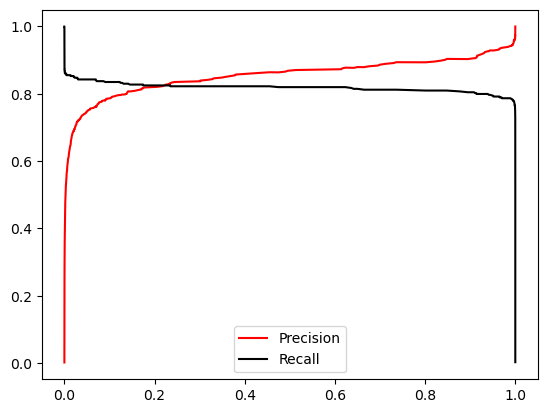

In [311]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='r', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()
plt.show()

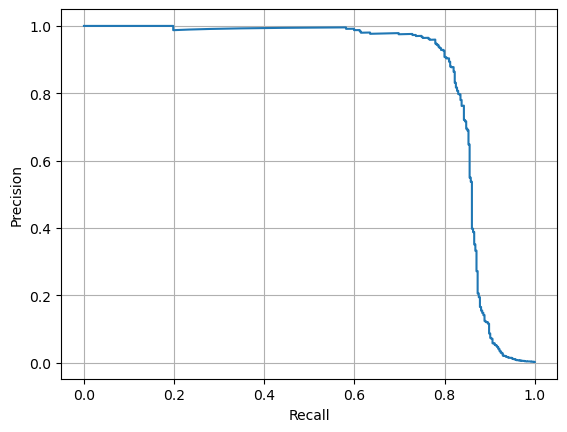

In [312]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [313]:
# changing threshold

In [314]:
threshold_90_precision = thresholds[(precision >= 0.90).argmax()]
threshold_90_precision

0.8447424665141051

In [315]:
y_pred_90_precision = (y_scores_lgbm_fraud >= threshold_90_precision)
y_pred_90_precision

array([False, False, False, ..., False, False, False])

In [294]:
precision_score(y_train, y_pred_90_precision)

0.9011299435028248

In [295]:
recall_score(y_train, y_pred_90_precision)

0.8096446700507615

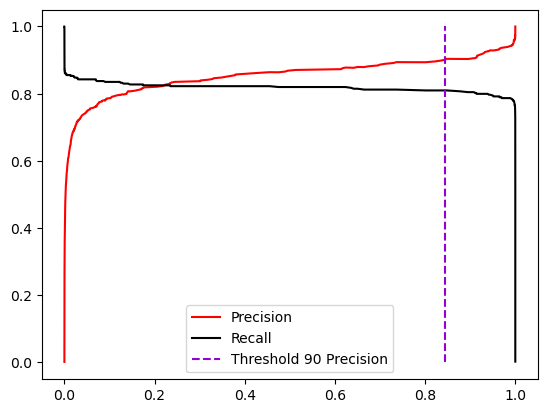

In [309]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')

ax.plot([threshold_90_precision, threshold_90_precision], [0,1],
        color='darkviolet', ls='--', label='Threshold 90 Precision')
ax.legend()
plt.show()

In [316]:
from sklearn.metrics import precision_score, recall_score, f1_score

**F1 score**

In [346]:
# if probability is over 0.5 return 1, else return 0
y_pred = (y_scores_lgbm[:, 1] > 0.5).astype(int)

In [347]:
precision_score(y_train, y_pred)

0.8706199460916442

In [348]:
recall_score(y_train, y_pred)

0.8197969543147208

In [349]:
f1_score(y_train, y_pred)

0.8444444444444444

**ROC Curve**

In [350]:
from sklearn.metrics import roc_curve

In [351]:
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_scores_lgbm_fraud)

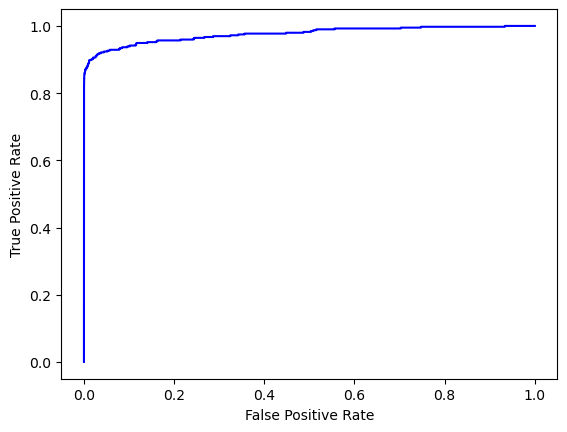

In [352]:
plt.plot(fpr, tpr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# working on test dataset

In [353]:
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x000001C4F0DB7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss', learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=0.5, verbose=-1))])

In [354]:
test_predit_lgbm = lgbm_pipeline.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [355]:
# f1 score on test data with LGBM

In [356]:
f1_score(y_test, test_predit_lgbm)

0.84375

In [357]:
y_score = lgbm_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [358]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

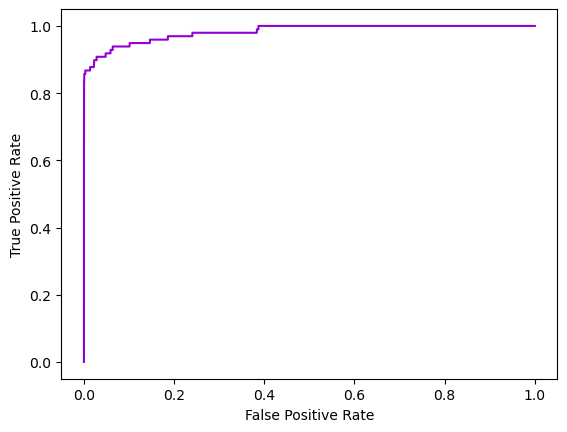

In [359]:
plt.plot(fpr, tpr, color='darkviolet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### roc_auc_score

In [363]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score)
auc

0.9825606100628209

In [366]:
y_score = lgbm_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [367]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    y_score=y_score,
)

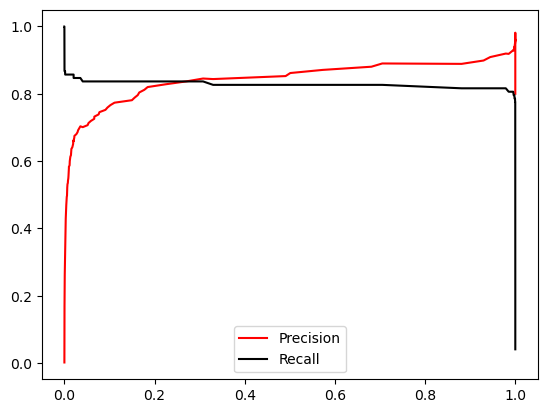

In [371]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()

plt.show()

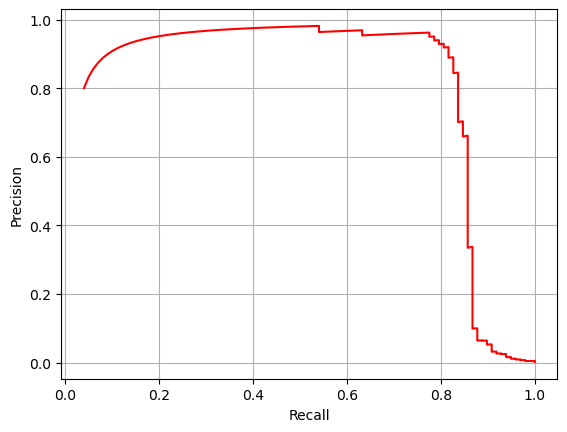

In [376]:
fig, ax = plt.subplots()
ax.plot(recall[:-1], precision[:-1], color='red',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.show()